### Bending modes test
performed on 3/6/20, repeated 3 times.

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters();

In [2]:
client = EfdClient('summit_efd')
csc_index = 1

### The test lasted about 20 minutes. Look at the entire data set to make sure we have everything.
* We put on bm1 position for 5s, then bm1 negative for 5s, then clear for 5s, then went onto bm2
* so each bending mode took 15s, we have 20 bending modes. Each repeat took 300s = 5 minutes
* we repeated 3 times. total testing time was 15 minutes.

In [3]:
start = Time('2020-03-06T13:20:30') #this is UTC
end = Time('2020-03-06T13:41:00') 

In [4]:
df = await client.select_time_series('lsst.sal.MTM2.axialForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

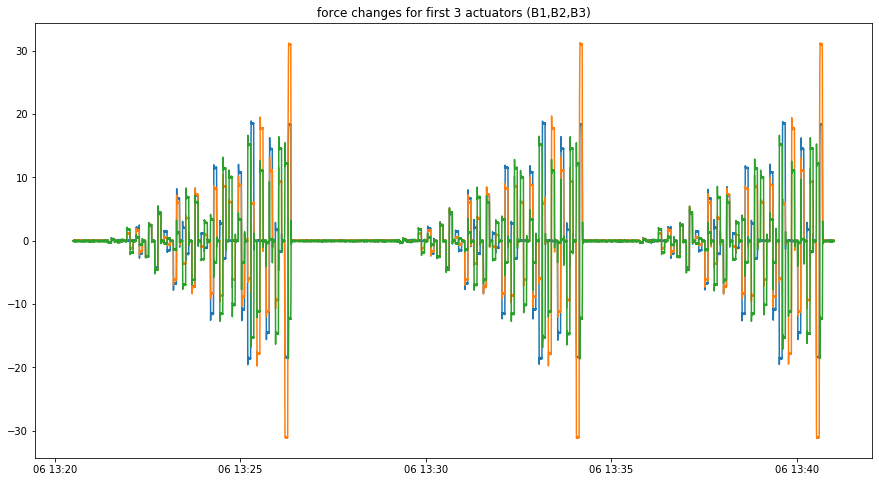

In [197]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(3):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['axialForceMeasured%d'%i]-df['axialForceMeasured%d'%i][0])
plt.title('force changes for first 3 actuators (B1,B2,B3)');

### How are we going to identify the timestamps we started each round (repeat)?
We will look at the RMS forces for all axial actuators

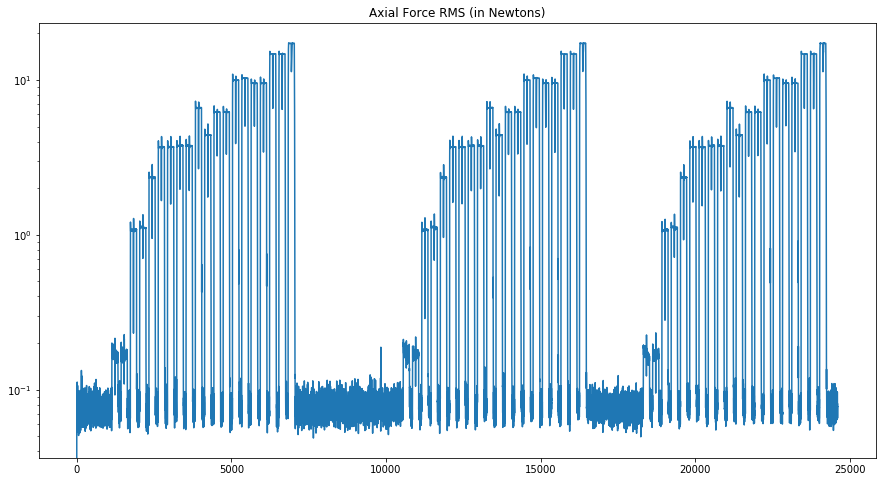

In [198]:
fig, ax = plt.subplots(figsize=(15,8))
#for i in range(72):
aa = sum([((df['axialForceMeasured%d'%i]-df['axialForceMeasured%d'%i][0])**2) for i in range(72)])
aa = np.array(np.sqrt(aa/72))
plt.semilogy( aa )
plt.title('Axial Force RMS (in Newtons)');

### Forces for the first two modes (astigmatisms) are small. Sometimes noise can be as high as that.
* We use bm3 for identifying the starting timestamp for each round.

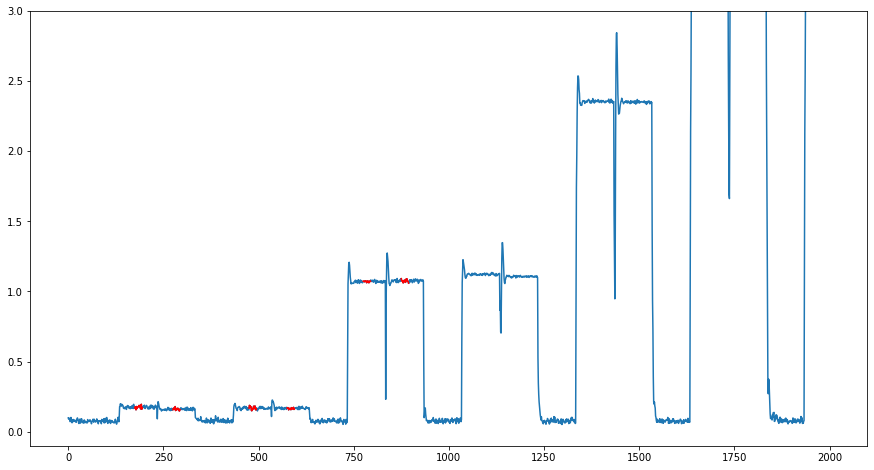

In [202]:
fig, ax = plt.subplots(figsize=(15,8))
#plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), aa )
plt.plot(aa[1000:3000])
plt.ylim([-0.1, 3])
base = np.argmax(aa>1.0)+40-300*2  #find 3rd bm, then walk back to 1st (1st/2nd can be confused with noise)
for i in range(3):
    idx = np.arange(base+i*300, base+i*300+20)  #20 data points, this is from +40 to +60, out of [0, 100]
    plt.plot(idx-1000, aa[idx], 'r')
    plt.plot(idx+100-1000, aa[idx+100], 'r')

### Build an array to store the data we need.

In [37]:
bm = np.zeros((20, 78, 4, 2))
#1st dimension: bending mode
#2nd : actuator (including tangent links)
#3rd, round (applied forces, then round#1, #2, and #3)
#4th, position forces (0) or negative forces (1)

#### Fill in the applied forces

In [105]:
bmIn = np.loadtxt('../github/data/M2_1um_72_force.txt')
for i in range(20):
    if i<10:
        scalef = 1./2
    elif i<15:
        scalef = 1./3
    else:
        scalef = 1./4
    if i<17:
        bm[i,:72,0,0] = bmIn[:,i+3]*scalef
        bm[i,:72,0,1] = -bmIn[:,i+3]*scalef
    else: #We used the mat file to create csv file during the test. 
        #But the txt above is after we swapped 26,27,28 for 18,19,20
        bm[i,:72,0,0] = bmIn[:,i+11]*scalef
        bm[i,:72,0,1] = -bmIn[:,i+11]*scalef        

#### Fill in the measured forces
* The average of 20 data points (1s) becomes one element in the above array.
* In an earlier version of this notebook, we used 60 data points for each average: from 20 to 80 out of the [0,100]. Then we observed "force inaccuracy" for a few actuators with bending mode#20. It was because the forces did not have enough time to settle with the high order bending mode, where force magnitudes were high. The "force inaccuracy" also only affected negative modes, because going from 0 to positive modes the change in force is 1/2 of the change of going from positive to negative. Larger force changes take longer to settle.

In [241]:
for iround in range(3):
    if iround==0:
        start = Time('2020-03-06T13:20:30') #this is UTC
        end = Time('2020-03-06T13:28:00') 
    elif iround == 1:
        start = Time('2020-03-06T13:28:00') #this is UTC
        end = Time('2020-03-06T13:36:00') 
    else:
        start = Time('2020-03-06T13:35:30') #this is UTC
        end = Time('2020-03-06T13:41:00') 
    dfa = await client.select_time_series('lsst.sal.MTM2.axialForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
    dft = await client.select_time_series('lsst.sal.MTM2.tangentForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
    aa = sum([((dfa['axialForceMeasured%d'%i]-dfa['axialForceMeasured%d'%i][0])**2) for i in range(72)])
    aa = np.array(np.sqrt(aa/72))
    base = np.argmax(aa>1.0)+40-300*2 #find 3rd bm, then walk back to 1st (1st/2nd can be confused with noise)
    assert base>0
    for i in range(20):     
        idx = np.arange(base+i*300, base+i*300+20) #20 data points, this is from +40 to +60, out of [0, 100]
        for iact in range(78):
            if iact<72:
                bm[i,iact,iround+1, 0] = np.mean(np.array(dfa['axialForceMeasured%d'%iact][idx])-
                                           np.array(dfa['axialForceMeasured%d'%iact][idx-100]))
                bm[i,iact,iround+1, 1] = np.mean(np.array(dfa['axialForceMeasured%d'%iact][idx+100])-
                                           np.array(dfa['axialForceMeasured%d'%iact][idx-100]))
            else:
                bm[i,iact,iround+1, 0] = np.mean(np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx])-
                                           np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx-100]))
                bm[i,iact,iround+1, 1] = np.mean(np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx+100])-
                                           np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx-100]))
            if abs(bm[i,iact,iround+1, 0] - bm[i,iact, 0 , 0])>2 or abs(bm[i,iact,iround+1, 1]- bm[i,iact, 0, 1])>2:
                errorS = '=============='
            else:
                errorS =''
            print('bm%2d, act#%2d, round%d, idx[0] = %.0f, force = %.2fN/%.2fN and %.2fN/%.2fN, %s'%(
                i+1,iact+1, iround+1, idx[0], 
                bm[i,iact,iround+1, 0],bm[i,iact, 0 , 0], bm[i,iact,iround+1, 1], bm[i,iact, 0, 1], errorS))

bm 1, act# 1, round1, idx[0] = 1175, force = -0.25N/-0.25N and 0.29N/0.25N, 
bm 1, act# 2, round1, idx[0] = 1175, force = -0.27N/-0.26N and 0.23N/0.26N, 
bm 1, act# 3, round1, idx[0] = 1175, force = -0.20N/-0.21N and 0.22N/0.21N, 
bm 1, act# 4, round1, idx[0] = 1175, force = -0.11N/-0.13N and 0.16N/0.13N, 
bm 1, act# 5, round1, idx[0] = 1175, force = -0.04N/-0.03N and 0.02N/0.03N, 
bm 1, act# 6, round1, idx[0] = 1175, force = 0.07N/0.08N and -0.09N/-0.08N, 
bm 1, act# 7, round1, idx[0] = 1175, force = 0.19N/0.17N and -0.20N/-0.17N, 
bm 1, act# 8, round1, idx[0] = 1175, force = 0.26N/0.24N and -0.25N/-0.24N, 
bm 1, act# 9, round1, idx[0] = 1175, force = 0.22N/0.26N and -0.31N/-0.26N, 
bm 1, act#10, round1, idx[0] = 1175, force = 0.20N/0.24N and -0.25N/-0.24N, 
bm 1, act#11, round1, idx[0] = 1175, force = 0.18N/0.18N and -0.15N/-0.18N, 
bm 1, act#12, round1, idx[0] = 1175, force = 0.08N/0.08N and -0.07N/-0.08N, 
bm 1, act#13, round1, idx[0] = 1175, force = -0.02N/-0.02N and 0.02N/0.02N, 

bm 3, act#76, round1, idx[0] = 1775, force = 0.06N/0.00N and 0.46N/0.00N, 
bm 3, act#77, round1, idx[0] = 1775, force = 0.04N/0.00N and 0.33N/0.00N, 
bm 3, act#78, round1, idx[0] = 1775, force = 0.32N/0.00N and 0.40N/0.00N, 
bm 4, act# 1, round1, idx[0] = 2075, force = 1.98N/2.00N and -2.02N/-2.00N, 
bm 4, act# 2, round1, idx[0] = 2075, force = 1.64N/1.62N and -1.62N/-1.62N, 
bm 4, act# 3, round1, idx[0] = 2075, force = 0.59N/0.62N and -0.65N/-0.62N, 
bm 4, act# 4, round1, idx[0] = 2075, force = -0.62N/-0.64N and 0.65N/0.64N, 
bm 4, act# 5, round1, idx[0] = 2075, force = -1.64N/-1.64N and 1.65N/1.64N, 
bm 4, act# 6, round1, idx[0] = 2075, force = -2.02N/-2.02N and 2.01N/2.02N, 
bm 4, act# 7, round1, idx[0] = 2075, force = -1.64N/-1.64N and 1.66N/1.64N, 
bm 4, act# 8, round1, idx[0] = 2075, force = -0.62N/-0.63N and 0.60N/0.63N, 
bm 4, act# 9, round1, idx[0] = 2075, force = 0.61N/0.62N and -0.61N/-0.62N, 
bm 4, act#10, round1, idx[0] = 2075, force = 1.64N/1.62N and -1.64N/-1.62N, 
bm 4,

bm 6, act#74, round1, idx[0] = 2675, force = -0.12N/0.00N and 0.13N/0.00N, 
bm 6, act#75, round1, idx[0] = 2675, force = 0.00N/0.00N and 0.38N/0.00N, 
bm 6, act#76, round1, idx[0] = 2675, force = -0.02N/0.00N and 0.26N/0.00N, 
bm 6, act#77, round1, idx[0] = 2675, force = 0.20N/0.00N and 0.40N/0.00N, 
bm 6, act#78, round1, idx[0] = 2675, force = -0.04N/0.00N and 0.17N/0.00N, 
bm 7, act# 1, round1, idx[0] = 2975, force = 1.47N/1.49N and -1.47N/-1.49N, 
bm 7, act# 2, round1, idx[0] = 2975, force = 0.57N/0.57N and -0.56N/-0.57N, 
bm 7, act# 3, round1, idx[0] = 2975, force = -0.40N/-0.38N and 0.39N/0.38N, 
bm 7, act# 4, round1, idx[0] = 2975, force = -1.28N/-1.31N and 1.32N/1.31N, 
bm 7, act# 5, round1, idx[0] = 2975, force = -2.21N/-2.17N and 2.17N/2.17N, 
bm 7, act# 6, round1, idx[0] = 2975, force = -2.93N/-2.95N and 2.97N/2.95N, 
bm 7, act# 7, round1, idx[0] = 2975, force = -3.61N/-3.61N and 3.63N/3.61N, 
bm 7, act# 8, round1, idx[0] = 2975, force = -4.10N/-4.13N and 4.15N/4.13N, 
bm 7, 

bm 9, act#71, round1, idx[0] = 3575, force = 0.12N/0.12N and -0.13N/-0.12N, 
bm 9, act#72, round1, idx[0] = 3575, force = 2.45N/2.42N and -2.40N/-2.42N, 
bm 9, act#73, round1, idx[0] = 3575, force = -0.22N/0.00N and 0.07N/0.00N, 
bm 9, act#74, round1, idx[0] = 3575, force = -0.15N/0.00N and -0.13N/0.00N, 
bm 9, act#75, round1, idx[0] = 3575, force = 0.12N/0.00N and 0.06N/0.00N, 
bm 9, act#76, round1, idx[0] = 3575, force = 0.01N/0.00N and 0.07N/0.00N, 
bm 9, act#77, round1, idx[0] = 3575, force = 0.08N/0.00N and -0.05N/0.00N, 
bm 9, act#78, round1, idx[0] = 3575, force = 0.17N/0.00N and 0.17N/0.00N, 
bm10, act# 1, round1, idx[0] = 3875, force = -7.24N/-7.21N and 7.21N/7.21N, 
bm10, act# 2, round1, idx[0] = 3875, force = -7.28N/-7.28N and 7.29N/7.28N, 
bm10, act# 3, round1, idx[0] = 3875, force = -6.12N/-6.13N and 6.17N/6.13N, 
bm10, act# 4, round1, idx[0] = 3875, force = -3.90N/-3.87N and 3.85N/3.87N, 
bm10, act# 5, round1, idx[0] = 3875, force = -0.92N/-0.90N and 0.91N/0.90N, 
bm10, a

bm12, act#72, round1, idx[0] = 4475, force = 1.40N/1.35N and -1.32N/-1.35N, 
bm12, act#73, round1, idx[0] = 4475, force = 0.02N/0.00N and 0.25N/0.00N, 
bm12, act#74, round1, idx[0] = 4475, force = -0.20N/0.00N and 0.15N/0.00N, 
bm12, act#75, round1, idx[0] = 4475, force = -0.09N/0.00N and 0.08N/0.00N, 
bm12, act#76, round1, idx[0] = 4475, force = -0.15N/0.00N and -0.41N/0.00N, 
bm12, act#77, round1, idx[0] = 4475, force = -0.05N/0.00N and -0.43N/0.00N, 
bm12, act#78, round1, idx[0] = 4475, force = -0.12N/0.00N and -0.25N/0.00N, 
bm13, act# 1, round1, idx[0] = 4775, force = 2.79N/2.77N and -2.74N/-2.77N, 
bm13, act# 2, round1, idx[0] = 4775, force = -8.61N/-8.63N and 8.69N/8.63N, 
bm13, act# 3, round1, idx[0] = 4775, force = -11.48N/-11.49N and 11.49N/11.49N, 
bm13, act# 4, round1, idx[0] = 4775, force = -2.79N/-2.76N and 2.77N/2.76N, 
bm13, act# 5, round1, idx[0] = 4775, force = 8.70N/8.73N and -8.71N/-8.73N, 
bm13, act# 6, round1, idx[0] = 4775, force = 11.35N/11.38N and -11.36N/-11.3

bm15, act#73, round1, idx[0] = 5375, force = 0.07N/0.00N and -0.19N/0.00N, 
bm15, act#74, round1, idx[0] = 5375, force = 0.13N/0.00N and 0.08N/0.00N, 
bm15, act#75, round1, idx[0] = 5375, force = -0.33N/0.00N and -0.14N/0.00N, 
bm15, act#76, round1, idx[0] = 5375, force = -0.34N/0.00N and -0.40N/0.00N, 
bm15, act#77, round1, idx[0] = 5375, force = -0.13N/0.00N and -0.22N/0.00N, 
bm15, act#78, round1, idx[0] = 5375, force = -0.08N/0.00N and -0.21N/0.00N, 
bm16, act# 1, round1, idx[0] = 5675, force = -18.55N/-18.57N and 18.52N/18.57N, 
bm16, act# 2, round1, idx[0] = 5675, force = -5.90N/-5.94N and 5.97N/5.94N, 
bm16, act# 3, round1, idx[0] = 5675, force = 15.25N/15.22N and -15.19N/-15.22N, 
bm16, act# 4, round1, idx[0] = 5675, force = 15.25N/15.24N and -15.26N/-15.24N, 
bm16, act# 5, round1, idx[0] = 5675, force = -5.96N/-5.91N and 5.87N/5.91N, 
bm16, act# 6, round1, idx[0] = 5675, force = -18.57N/-18.57N and 18.56N/18.57N, 
bm16, act# 7, round1, idx[0] = 5675, force = -5.92N/-5.94N and 

bm18, act#74, round1, idx[0] = 6275, force = 0.27N/0.00N and 0.21N/0.00N, 
bm18, act#75, round1, idx[0] = 6275, force = -0.02N/0.00N and 0.16N/0.00N, 
bm18, act#76, round1, idx[0] = 6275, force = -0.13N/0.00N and -0.04N/0.00N, 
bm18, act#77, round1, idx[0] = 6275, force = -0.15N/0.00N and 0.33N/0.00N, 
bm18, act#78, round1, idx[0] = 6275, force = -0.15N/0.00N and -0.42N/0.00N, 
bm19, act# 1, round1, idx[0] = 6575, force = 1.73N/1.73N and -1.76N/-1.73N, 
bm19, act# 2, round1, idx[0] = 6575, force = -9.35N/-9.33N and 9.35N/9.33N, 
bm19, act# 3, round1, idx[0] = 6575, force = -14.64N/-14.63N and 14.63N/14.63N, 
bm19, act# 4, round1, idx[0] = 6575, force = -9.93N/-9.91N and 9.91N/9.91N, 
bm19, act# 5, round1, idx[0] = 6575, force = 1.60N/1.59N and -1.56N/-1.59N, 
bm19, act# 6, round1, idx[0] = 6575, force = 11.65N/11.69N and -11.67N/-11.69N, 
bm19, act# 7, round1, idx[0] = 6575, force = 14.27N/14.28N and -14.27N/-14.28N, 
bm19, act# 8, round1, idx[0] = 6575, force = 7.51N/7.54N and -7.49N/

bm 1, act# 1, round2, idx[0] = 1595, force = -0.26N/-0.25N and 0.25N/0.25N, 
bm 1, act# 2, round2, idx[0] = 1595, force = -0.26N/-0.26N and 0.23N/0.26N, 
bm 1, act# 3, round2, idx[0] = 1595, force = -0.23N/-0.21N and 0.20N/0.21N, 
bm 1, act# 4, round2, idx[0] = 1595, force = -0.12N/-0.13N and 0.16N/0.13N, 
bm 1, act# 5, round2, idx[0] = 1595, force = -0.04N/-0.03N and 0.05N/0.03N, 
bm 1, act# 6, round2, idx[0] = 1595, force = 0.08N/0.08N and -0.07N/-0.08N, 
bm 1, act# 7, round2, idx[0] = 1595, force = 0.18N/0.17N and -0.15N/-0.17N, 
bm 1, act# 8, round2, idx[0] = 1595, force = 0.22N/0.24N and -0.23N/-0.24N, 
bm 1, act# 9, round2, idx[0] = 1595, force = 0.27N/0.26N and -0.24N/-0.26N, 
bm 1, act#10, round2, idx[0] = 1595, force = 0.23N/0.24N and -0.24N/-0.24N, 
bm 1, act#11, round2, idx[0] = 1595, force = 0.18N/0.18N and -0.17N/-0.18N, 
bm 1, act#12, round2, idx[0] = 1595, force = 0.08N/0.08N and -0.07N/-0.08N, 
bm 1, act#13, round2, idx[0] = 1595, force = -0.03N/-0.02N and 0.05N/0.02N, 

bm 4, act# 4, round2, idx[0] = 2495, force = -0.64N/-0.64N and 0.64N/0.64N, 
bm 4, act# 5, round2, idx[0] = 2495, force = -1.66N/-1.64N and 1.66N/1.64N, 
bm 4, act# 6, round2, idx[0] = 2495, force = -2.02N/-2.02N and 2.02N/2.02N, 
bm 4, act# 7, round2, idx[0] = 2495, force = -1.64N/-1.64N and 1.61N/1.64N, 
bm 4, act# 8, round2, idx[0] = 2495, force = -0.65N/-0.63N and 0.60N/0.63N, 
bm 4, act# 9, round2, idx[0] = 2495, force = 0.62N/0.62N and -0.64N/-0.62N, 
bm 4, act#10, round2, idx[0] = 2495, force = 1.63N/1.62N and -1.59N/-1.62N, 
bm 4, act#11, round2, idx[0] = 2495, force = 2.00N/2.00N and -2.03N/-2.00N, 
bm 4, act#12, round2, idx[0] = 2495, force = 1.63N/1.62N and -1.65N/-1.62N, 
bm 4, act#13, round2, idx[0] = 2495, force = 0.59N/0.62N and -0.62N/-0.62N, 
bm 4, act#14, round2, idx[0] = 2495, force = -0.63N/-0.64N and 0.63N/0.64N, 
bm 4, act#15, round2, idx[0] = 2495, force = -1.63N/-1.64N and 1.64N/1.64N, 
bm 4, act#16, round2, idx[0] = 2495, force = -2.02N/-2.02N and 2.00N/2.02N, 

bm 6, act#76, round2, idx[0] = 3095, force = 0.17N/0.00N and 0.20N/0.00N, 
bm 6, act#77, round2, idx[0] = 3095, force = 0.32N/0.00N and -0.11N/0.00N, 
bm 6, act#78, round2, idx[0] = 3095, force = -0.18N/0.00N and 0.11N/0.00N, 
bm 7, act# 1, round2, idx[0] = 3395, force = 1.46N/1.49N and -1.48N/-1.49N, 
bm 7, act# 2, round2, idx[0] = 3395, force = 0.57N/0.57N and -0.57N/-0.57N, 
bm 7, act# 3, round2, idx[0] = 3395, force = -0.39N/-0.38N and 0.34N/0.38N, 
bm 7, act# 4, round2, idx[0] = 3395, force = -1.33N/-1.31N and 1.32N/1.31N, 
bm 7, act# 5, round2, idx[0] = 3395, force = -2.16N/-2.17N and 2.17N/2.17N, 
bm 7, act# 6, round2, idx[0] = 3395, force = -2.97N/-2.95N and 2.93N/2.95N, 
bm 7, act# 7, round2, idx[0] = 3395, force = -3.57N/-3.61N and 3.62N/3.61N, 
bm 7, act# 8, round2, idx[0] = 3395, force = -4.13N/-4.13N and 4.14N/4.13N, 
bm 7, act# 9, round2, idx[0] = 3395, force = -4.42N/-4.44N and 4.45N/4.44N, 
bm 7, act#10, round2, idx[0] = 3395, force = -4.53N/-4.53N and 4.49N/4.53N, 
bm 

bm 9, act#69, round2, idx[0] = 3995, force = -1.00N/-0.96N and 0.89N/0.96N, 
bm 9, act#70, round2, idx[0] = 3995, force = -2.39N/-2.39N and 2.38N/2.39N, 
bm 9, act#71, round2, idx[0] = 3995, force = 0.11N/0.12N and -0.15N/-0.12N, 
bm 9, act#72, round2, idx[0] = 3995, force = 2.43N/2.42N and -2.39N/-2.42N, 
bm 9, act#73, round2, idx[0] = 3995, force = -0.12N/0.00N and -0.19N/0.00N, 
bm 9, act#74, round2, idx[0] = 3995, force = 0.02N/0.00N and 0.15N/0.00N, 
bm 9, act#75, round2, idx[0] = 3995, force = -0.15N/0.00N and 0.14N/0.00N, 
bm 9, act#76, round2, idx[0] = 3995, force = 0.08N/0.00N and 0.35N/0.00N, 
bm 9, act#77, round2, idx[0] = 3995, force = -0.07N/0.00N and -0.08N/0.00N, 
bm 9, act#78, round2, idx[0] = 3995, force = 0.14N/0.00N and 0.16N/0.00N, 
bm10, act# 1, round2, idx[0] = 4295, force = -7.24N/-7.21N and 7.24N/7.21N, 
bm10, act# 2, round2, idx[0] = 4295, force = -7.29N/-7.28N and 7.29N/7.28N, 
bm10, act# 3, round2, idx[0] = 4295, force = -6.11N/-6.13N and 6.16N/6.13N, 
bm10, 

bm12, act#71, round2, idx[0] = 4895, force = 2.81N/2.81N and -2.83N/-2.81N, 
bm12, act#72, round2, idx[0] = 4895, force = 1.37N/1.35N and -1.36N/-1.35N, 
bm12, act#73, round2, idx[0] = 4895, force = 0.05N/0.00N and 0.15N/0.00N, 
bm12, act#74, round2, idx[0] = 4895, force = -0.22N/0.00N and -0.06N/0.00N, 
bm12, act#75, round2, idx[0] = 4895, force = 0.02N/0.00N and 0.24N/0.00N, 
bm12, act#76, round2, idx[0] = 4895, force = 0.22N/0.00N and 0.04N/0.00N, 
bm12, act#77, round2, idx[0] = 4895, force = -0.17N/0.00N and -0.17N/0.00N, 
bm12, act#78, round2, idx[0] = 4895, force = 0.12N/0.00N and 0.27N/0.00N, 
bm13, act# 1, round2, idx[0] = 5195, force = 2.76N/2.77N and -2.79N/-2.77N, 
bm13, act# 2, round2, idx[0] = 5195, force = -8.64N/-8.63N and 8.63N/8.63N, 
bm13, act# 3, round2, idx[0] = 5195, force = -11.50N/-11.49N and 11.51N/11.49N, 
bm13, act# 4, round2, idx[0] = 5195, force = -2.79N/-2.76N and 2.74N/2.76N, 
bm13, act# 5, round2, idx[0] = 5195, force = 8.74N/8.73N and -8.66N/-8.73N, 
bm1

bm15, act#69, round2, idx[0] = 5795, force = 11.44N/11.44N and -11.44N/-11.44N, 
bm15, act#70, round2, idx[0] = 5795, force = 22.90N/22.85N and -22.82N/-22.85N, 
bm15, act#71, round2, idx[0] = 5795, force = 11.46N/11.44N and -11.44N/-11.44N, 
bm15, act#72, round2, idx[0] = 5795, force = -11.49N/-11.49N and 11.49N/11.49N, 
bm15, act#73, round2, idx[0] = 5795, force = 0.14N/0.00N and 0.04N/0.00N, 
bm15, act#74, round2, idx[0] = 5795, force = 0.12N/0.00N and 0.09N/0.00N, 
bm15, act#75, round2, idx[0] = 5795, force = 0.07N/0.00N and 0.31N/0.00N, 
bm15, act#76, round2, idx[0] = 5795, force = -0.11N/0.00N and -0.29N/0.00N, 
bm15, act#77, round2, idx[0] = 5795, force = 0.02N/0.00N and -0.19N/0.00N, 
bm15, act#78, round2, idx[0] = 5795, force = 0.05N/0.00N and -0.46N/0.00N, 
bm16, act# 1, round2, idx[0] = 6095, force = -18.54N/-18.57N and 18.53N/18.57N, 
bm16, act# 2, round2, idx[0] = 6095, force = -5.92N/-5.94N and 5.92N/5.94N, 
bm16, act# 3, round2, idx[0] = 6095, force = 15.23N/15.22N and -

bm18, act#74, round2, idx[0] = 6695, force = 0.07N/0.00N and -0.04N/0.00N, 
bm18, act#75, round2, idx[0] = 6695, force = -0.09N/0.00N and -0.36N/0.00N, 
bm18, act#76, round2, idx[0] = 6695, force = -0.11N/0.00N and -0.60N/0.00N, 
bm18, act#77, round2, idx[0] = 6695, force = -0.17N/0.00N and -0.13N/0.00N, 
bm18, act#78, round2, idx[0] = 6695, force = 0.19N/0.00N and 0.27N/0.00N, 
bm19, act# 1, round2, idx[0] = 6995, force = 1.73N/1.73N and -1.74N/-1.73N, 
bm19, act# 2, round2, idx[0] = 6995, force = -9.32N/-9.33N and 9.33N/9.33N, 
bm19, act# 3, round2, idx[0] = 6995, force = -14.65N/-14.63N and 14.63N/14.63N, 
bm19, act# 4, round2, idx[0] = 6995, force = -9.93N/-9.91N and 9.90N/9.91N, 
bm19, act# 5, round2, idx[0] = 6995, force = 1.57N/1.59N and -1.55N/-1.59N, 
bm19, act# 6, round2, idx[0] = 6995, force = 11.66N/11.69N and -11.67N/-11.69N, 
bm19, act# 7, round2, idx[0] = 6995, force = 14.30N/14.28N and -14.23N/-14.28N, 
bm19, act# 8, round2, idx[0] = 6995, force = 7.53N/7.54N and -7.49N

bm 1, act# 1, round3, idx[0] = 358, force = -0.27N/-0.25N and 0.25N/0.25N, 
bm 1, act# 2, round3, idx[0] = 358, force = -0.25N/-0.26N and 0.23N/0.26N, 
bm 1, act# 3, round3, idx[0] = 358, force = -0.23N/-0.21N and 0.21N/0.21N, 
bm 1, act# 4, round3, idx[0] = 358, force = -0.10N/-0.13N and 0.15N/0.13N, 
bm 1, act# 5, round3, idx[0] = 358, force = -0.02N/-0.03N and 0.05N/0.03N, 
bm 1, act# 6, round3, idx[0] = 358, force = 0.09N/0.08N and -0.07N/-0.08N, 
bm 1, act# 7, round3, idx[0] = 358, force = 0.21N/0.17N and -0.16N/-0.17N, 
bm 1, act# 8, round3, idx[0] = 358, force = 0.22N/0.24N and -0.26N/-0.24N, 
bm 1, act# 9, round3, idx[0] = 358, force = 0.26N/0.26N and -0.27N/-0.26N, 
bm 1, act#10, round3, idx[0] = 358, force = 0.24N/0.24N and -0.25N/-0.24N, 
bm 1, act#11, round3, idx[0] = 358, force = 0.19N/0.18N and -0.16N/-0.18N, 
bm 1, act#12, round3, idx[0] = 358, force = 0.10N/0.08N and -0.07N/-0.08N, 
bm 1, act#13, round3, idx[0] = 358, force = -0.05N/-0.02N and -0.01N/0.02N, 
bm 1, act#1

bm 4, act# 8, round3, idx[0] = 1258, force = -0.62N/-0.63N and 0.67N/0.63N, 
bm 4, act# 9, round3, idx[0] = 1258, force = 0.65N/0.62N and -0.61N/-0.62N, 
bm 4, act#10, round3, idx[0] = 1258, force = 1.61N/1.62N and -1.66N/-1.62N, 
bm 4, act#11, round3, idx[0] = 1258, force = 2.01N/2.00N and -1.99N/-2.00N, 
bm 4, act#12, round3, idx[0] = 1258, force = 1.63N/1.62N and -1.63N/-1.62N, 
bm 4, act#13, round3, idx[0] = 1258, force = 0.65N/0.62N and -0.62N/-0.62N, 
bm 4, act#14, round3, idx[0] = 1258, force = -0.64N/-0.64N and 0.62N/0.64N, 
bm 4, act#15, round3, idx[0] = 1258, force = -1.63N/-1.64N and 1.66N/1.64N, 
bm 4, act#16, round3, idx[0] = 1258, force = -2.00N/-2.02N and 2.03N/2.02N, 
bm 4, act#17, round3, idx[0] = 1258, force = -1.63N/-1.64N and 1.65N/1.64N, 
bm 4, act#18, round3, idx[0] = 1258, force = -0.62N/-0.63N and 0.63N/0.63N, 
bm 4, act#19, round3, idx[0] = 1258, force = 0.61N/0.62N and -0.59N/-0.62N, 
bm 4, act#20, round3, idx[0] = 1258, force = 1.61N/1.62N and -1.65N/-1.62N, 

bm 7, act#11, round3, idx[0] = 2158, force = -4.45N/-4.44N and 4.42N/4.44N, 
bm 7, act#12, round3, idx[0] = 2158, force = -4.16N/-4.17N and 4.11N/4.17N, 
bm 7, act#13, round3, idx[0] = 2158, force = -3.69N/-3.74N and 3.77N/3.74N, 
bm 7, act#14, round3, idx[0] = 2158, force = -3.14N/-3.13N and 3.13N/3.13N, 
bm 7, act#15, round3, idx[0] = 2158, force = -2.32N/-2.35N and 2.37N/2.35N, 
bm 7, act#16, round3, idx[0] = 2158, force = -1.50N/-1.49N and 1.46N/1.49N, 
bm 7, act#17, round3, idx[0] = 2158, force = -0.55N/-0.57N and 0.53N/0.57N, 
bm 7, act#18, round3, idx[0] = 2158, force = 0.39N/0.38N and -0.41N/-0.38N, 
bm 7, act#19, round3, idx[0] = 2158, force = 1.30N/1.31N and -1.32N/-1.31N, 
bm 7, act#20, round3, idx[0] = 2158, force = 2.18N/2.17N and -2.19N/-2.17N, 
bm 7, act#21, round3, idx[0] = 2158, force = 2.93N/2.95N and -2.96N/-2.95N, 
bm 7, act#22, round3, idx[0] = 2158, force = 3.61N/3.61N and -3.58N/-3.61N, 
bm 7, act#23, round3, idx[0] = 2158, force = 4.13N/4.13N and -4.16N/-4.13N, 

bm10, act#17, round3, idx[0] = 3058, force = -7.24N/-7.28N and 7.29N/7.28N, 
bm10, act#18, round3, idx[0] = 3058, force = -6.13N/-6.13N and 6.10N/6.13N, 
bm10, act#19, round3, idx[0] = 3058, force = -3.86N/-3.87N and 3.85N/3.87N, 
bm10, act#20, round3, idx[0] = 3058, force = -0.84N/-0.90N and 0.93N/0.90N, 
bm10, act#21, round3, idx[0] = 3058, force = 2.18N/2.16N and -2.12N/-2.16N, 
bm10, act#22, round3, idx[0] = 3058, force = 4.83N/4.86N and -4.92N/-4.86N, 
bm10, act#23, round3, idx[0] = 3058, force = 6.81N/6.80N and -6.80N/-6.80N, 
bm10, act#24, round3, idx[0] = 3058, force = 7.46N/7.49N and -7.50N/-7.49N, 
bm10, act#25, round3, idx[0] = 3058, force = 6.84N/6.82N and -6.79N/-6.82N, 
bm10, act#26, round3, idx[0] = 3058, force = 5.03N/5.05N and -5.04N/-5.05N, 
bm10, act#27, round3, idx[0] = 3058, force = 2.38N/2.41N and -2.42N/-2.41N, 
bm10, act#28, round3, idx[0] = 3058, force = -0.67N/-0.67N and 0.68N/0.67N, 
bm10, act#29, round3, idx[0] = 3058, force = -3.64N/-3.62N and 3.60N/3.62N, 

bm13, act#19, round3, idx[0] = 3958, force = 2.79N/2.76N and -2.76N/-2.76N, 
bm13, act#20, round3, idx[0] = 3958, force = -8.69N/-8.73N and 8.73N/8.73N, 
bm13, act#21, round3, idx[0] = 3958, force = -11.31N/-11.38N and 11.40N/11.38N, 
bm13, act#22, round3, idx[0] = 3958, force = -2.83N/-2.86N and 2.86N/2.86N, 
bm13, act#23, round3, idx[0] = 3958, force = 8.69N/8.67N and -8.69N/-8.67N, 
bm13, act#24, round3, idx[0] = 3958, force = 11.43N/11.47N and -11.50N/-11.47N, 
bm13, act#25, round3, idx[0] = 3958, force = 2.77N/2.72N and -2.70N/-2.72N, 
bm13, act#26, round3, idx[0] = 3958, force = -8.58N/-8.62N and 8.63N/8.62N, 
bm13, act#27, round3, idx[0] = 3958, force = -11.48N/-11.49N and 11.50N/11.49N, 
bm13, act#28, round3, idx[0] = 3958, force = -2.79N/-2.82N and 2.83N/2.82N, 
bm13, act#29, round3, idx[0] = 3958, force = 8.74N/8.71N and -8.70N/-8.71N, 
bm13, act#30, round3, idx[0] = 3958, force = 11.46N/11.45N and -11.42N/-11.45N, 
bm13, act#31, round3, idx[0] = 3958, force = -2.72N/-2.72N a

bm16, act#20, round3, idx[0] = 4858, force = -5.89N/-5.91N and 5.87N/5.91N, 
bm16, act#21, round3, idx[0] = 4858, force = -18.53N/-18.57N and 18.54N/18.57N, 
bm16, act#22, round3, idx[0] = 4858, force = -5.91N/-5.94N and 5.93N/5.94N, 
bm16, act#23, round3, idx[0] = 4858, force = 15.23N/15.22N and -15.26N/-15.22N, 
bm16, act#24, round3, idx[0] = 4858, force = 15.28N/15.24N and -15.27N/-15.24N, 
bm16, act#25, round3, idx[0] = 4858, force = -5.93N/-5.91N and 5.89N/5.91N, 
bm16, act#26, round3, idx[0] = 4858, force = -18.54N/-18.57N and 18.55N/18.57N, 
bm16, act#27, round3, idx[0] = 4858, force = -5.90N/-5.94N and 5.94N/5.94N, 
bm16, act#28, round3, idx[0] = 4858, force = 15.24N/15.22N and -15.24N/-15.22N, 
bm16, act#29, round3, idx[0] = 4858, force = 15.24N/15.24N and -15.27N/-15.24N, 
bm16, act#30, round3, idx[0] = 4858, force = -5.88N/-5.91N and 5.89N/5.91N, 
bm16, act#31, round3, idx[0] = 4858, force = -6.80N/-6.82N and 6.81N/6.82N, 
bm16, act#32, round3, idx[0] = 4858, force = 6.83N/6

bm19, act#21, round3, idx[0] = 5758, force = 11.72N/11.69N and -11.69N/-11.69N, 
bm19, act#22, round3, idx[0] = 5758, force = 14.32N/14.28N and -14.28N/-14.28N, 
bm19, act#23, round3, idx[0] = 5758, force = 7.56N/7.54N and -7.55N/-7.54N, 
bm19, act#24, round3, idx[0] = 5758, force = -4.34N/-4.37N and 4.32N/4.37N, 
bm19, act#25, round3, idx[0] = 5758, force = -13.26N/-13.28N and 13.28N/13.28N, 
bm19, act#26, round3, idx[0] = 5758, force = -13.39N/-13.43N and 13.41N/13.43N, 
bm19, act#27, round3, idx[0] = 5758, force = -4.87N/-4.94N and 4.90N/4.94N, 
bm19, act#28, round3, idx[0] = 5758, force = 7.11N/7.09N and -7.09N/-7.09N, 
bm19, act#29, round3, idx[0] = 5758, force = 14.33N/14.28N and -14.30N/-14.28N, 
bm19, act#30, round3, idx[0] = 5758, force = 11.72N/11.69N and -11.65N/-11.69N, 
bm19, act#31, round3, idx[0] = 5758, force = 6.25N/6.26N and -6.29N/-6.26N, 
bm19, act#32, round3, idx[0] = 5758, force = 15.92N/15.93N and -15.92N/-15.93N, 
bm19, act#33, round3, idx[0] = 5758, force = 9.5

In [237]:
bm.shape

(20, 78, 4, 2)

In [242]:
bm[0,0,:,1]

array([0.25479945, 0.28628082, 0.25030441, 0.25156555])

### Plot the bending forces: applied verus measured (mean and error bar).
* Error bars are due to 3 rounds of measurements

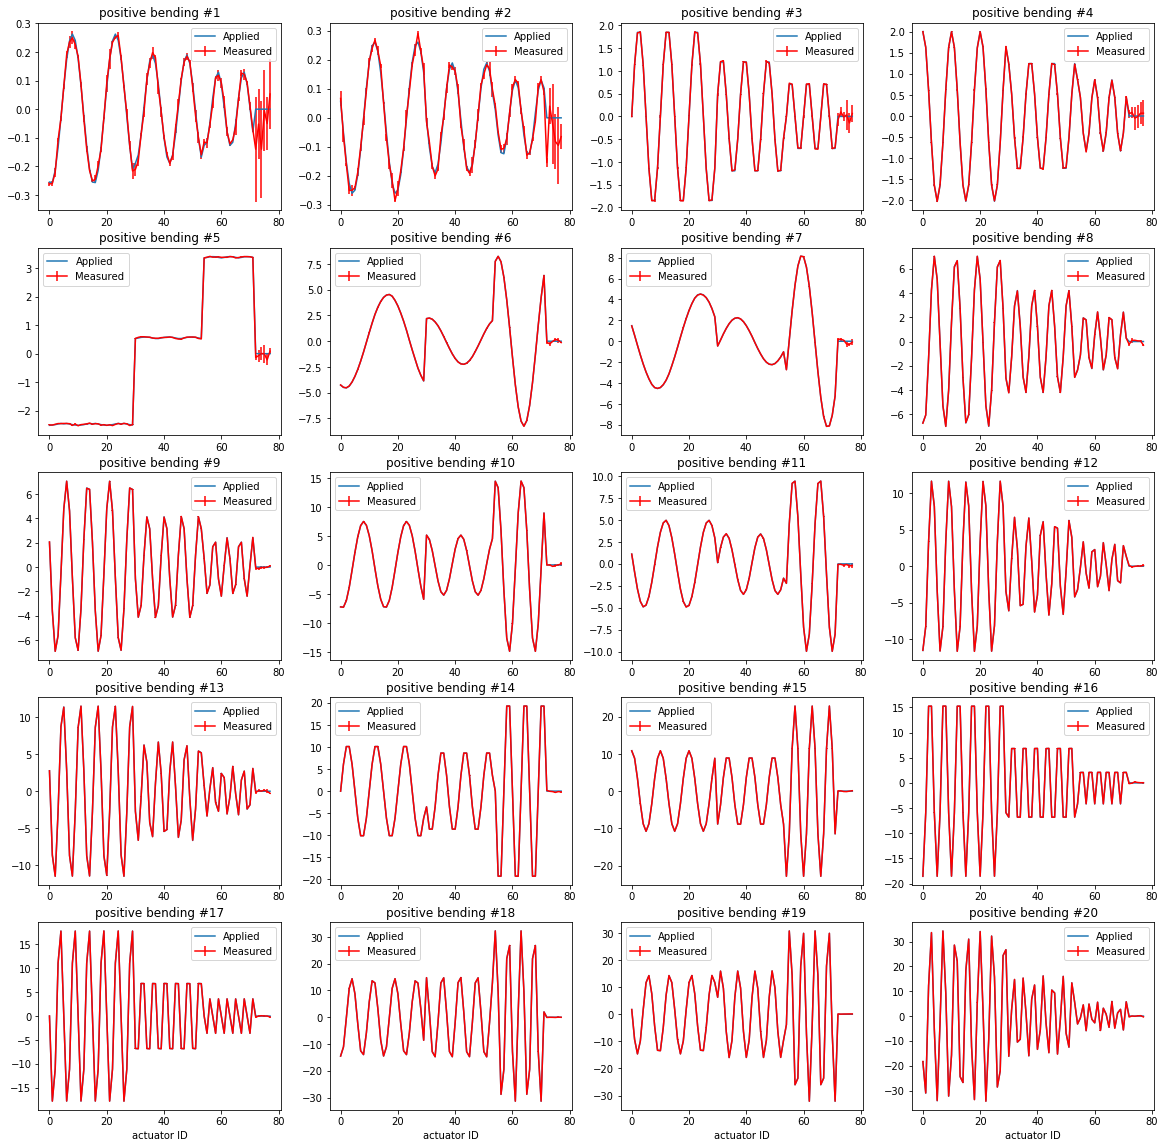

In [244]:
x0 = np.arange(78)
fig, ax = plt.subplots(5,4,figsize=(20,20))
for i in range(20):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].plot(x0, bm[i,:,0,0], label='Applied')
    ax[irow][icol].errorbar(x0, np.mean(bm[i,:,1:,0], axis=1), np.std(bm[i,:,1:,0], axis=1),color='r', label='Measured')
    ax[irow][icol].set_title('positive bending #%d'%(i+1))
    ax[irow][icol].legend()
    if irow == 4:
        ax[irow][icol].set_xlabel('actuator ID')

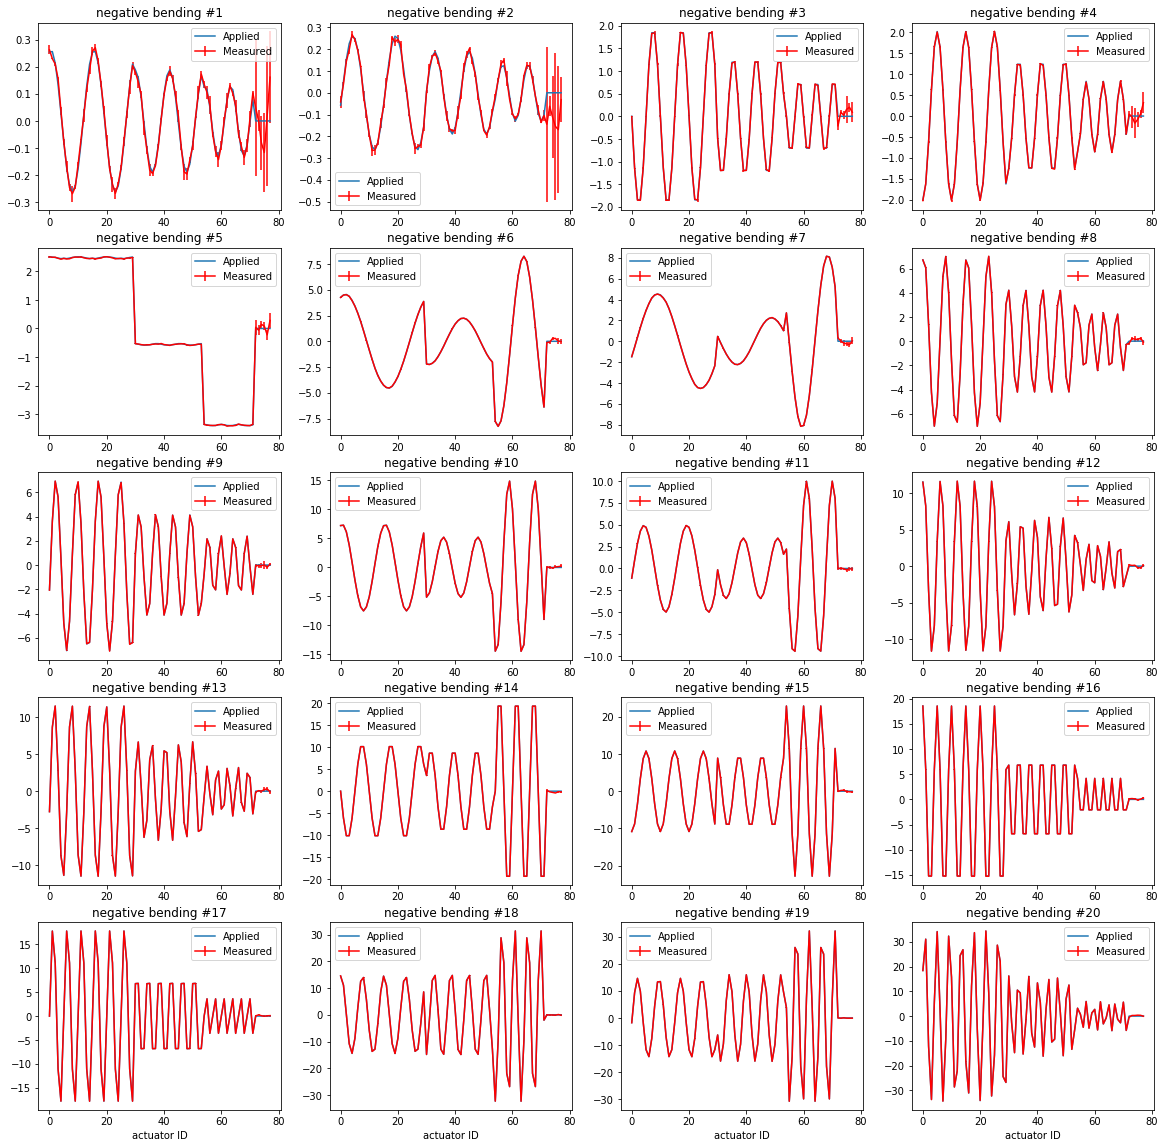

In [245]:
x0 = np.arange(78)
fig, ax = plt.subplots(5,4,figsize=(20,20))
for i in range(20):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].plot(x0, bm[i,:,0,1], label='Applied')
    ax[irow][icol].errorbar(x0, np.mean(bm[i,:,1:,1], axis=1), np.std(bm[i,:,1:,1], axis=1),color='r', label='Measured')
    ax[irow][icol].set_title('negative bending #%d'%(i+1))
    ax[irow][icol].legend()
    if irow == 4:
        ax[irow][icol].set_xlabel('actuator ID')

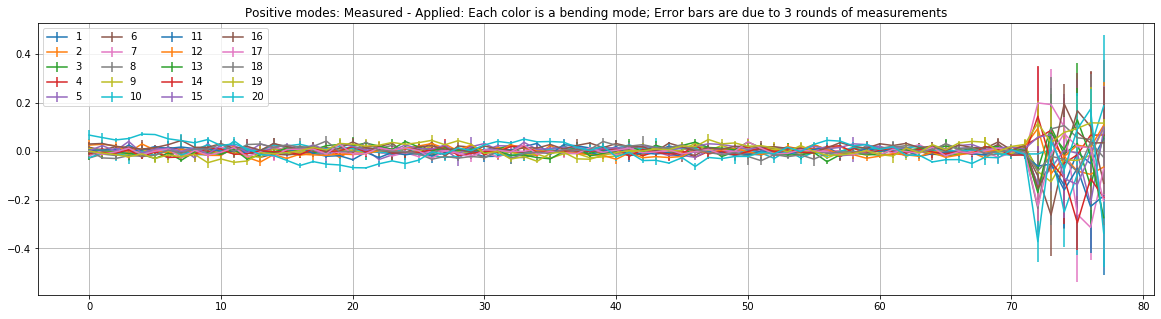

In [254]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,5))
for i in range(20):
    aa = bm[i,:,1:,0] - np.repeat(bm[i,:,0,0].reshape(-1,1),3, axis=1)
    plt.errorbar(x0, np.mean(aa, axis=1), np.std(aa, axis=1), label='%d'%(i+1))
plt.title('Positive modes: Measured - Applied: Each color is a bending mode; \
Error bars are due to 3 rounds of measurements');
plt.grid()
plt.legend(ncol=4);

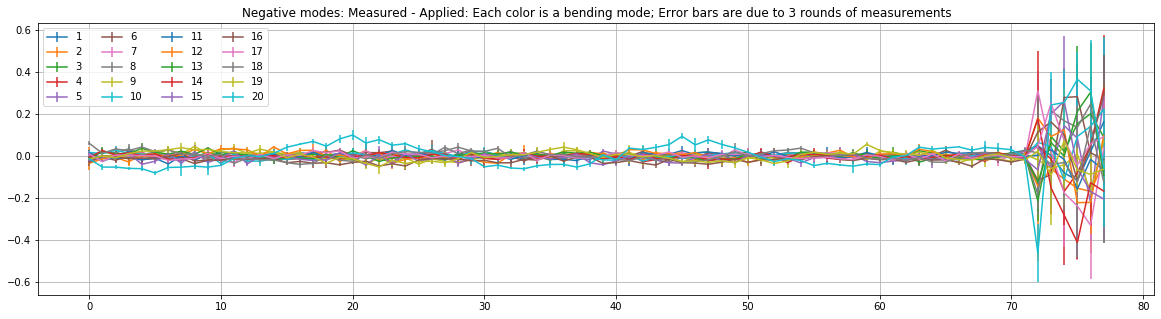

In [256]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,5))
for i in range(20):
    aa = bm[i,:,1:,1] - np.repeat(bm[i,:,0,1].reshape(-1,1),3, axis=1)
    plt.errorbar(x0, np.mean(aa, axis=1), np.std(aa, axis=1), label='%d'%(i+1))
plt.title('Negative modes: Measured - Applied: Each color is a bending mode; \
Error bars are due to 3 rounds of measurements');
plt.grid()
plt.legend(ncol=4);

### Final force error by actuator

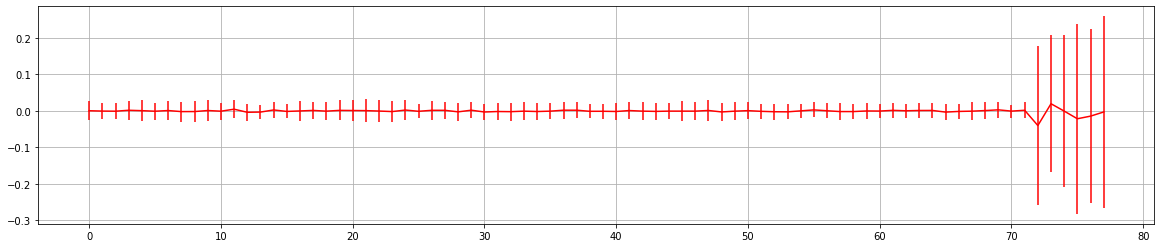

In [257]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,4))
aa = bm[:,:,1:,0]-np.repeat(bm[:,:,0,0].reshape(20,78,1),3, axis=2)
bb = bm[:,:,1:,1]-np.repeat(bm[:,:,0,1].reshape(20,78,1),3, axis=2)
aa = np.concatenate((aa, bb), axis=2)
bb = np.swapaxes(aa,1,2).reshape((-1,78))
plt.errorbar(x0, np.mean(bb, axis=0), np.std(bb, axis=0),color='r')
plt.grid()

#### Below was used by an earlier verion of the notebook to track down where large force errors were happening.
* It turned out that those seemingly large force errors were because we averaged over 3s instead of the currently used 1s.

In [258]:
print(aa.shape)
np.where(abs(aa)>2)

(20, 78, 6)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

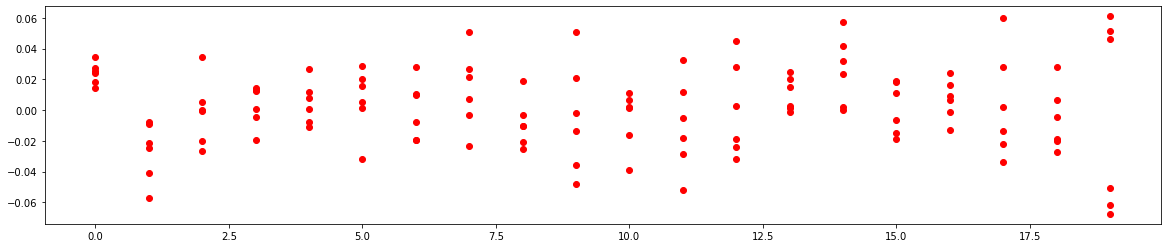

In [259]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(aa[:,3,:],'ro');